In [1]:
%config InlineBackend.figure_formats = ['retina']
%pylab inline


# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import scipy.stats as stats

# Linear Regression imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, lars_path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm

from model_helper import *

Populating the interactive namespace from numpy and matplotlib


# Pull in data from preprocessing

In [2]:
data_full = pd.read_csv('data_full.csv')

# Cleaning full dataset

## Drop players where ages do not approximately match (likely a scraping error)

Scraping data involved just searching for a player's name on FBref.com. Lots of players have the same name so it's possible that the scraper could have found the wrong player.

In [3]:
data_full = data_full[abs(data_full.age_x - data_full.age_y) <= 2]

## Drop players where goals per shot on target > 1 (likely a data error)

In [4]:
data_full = data_full[data_full.goals_per_shot_on_target <=1]

## Select columns from full data

In [5]:
target_cols = ['player_name', 'age_y', 'goals', 'in_play_goals', 'pens_made', 'pens_att',
              'shots_total', 'shots_on_target', 'shots_on_target_pct', 'shots_on_target_per90', 'goals_per_shot_on_target',
              'assists', 'games', 'minutes', 'minutes_90s', 'games_starts', 'games_subs', 'unused_subs',
              'on_goals_for', 'on_goals_against', 'plus_minus', 'cards_red', 'cards_yellow', 'fouls',
              'fee_cleaned']
target_data = data_full.loc[:, target_cols]
target_data = target_data.set_index('player_name')

# Drop Neymar because his fee is a crazy outlier
target_data = target_data.drop('Neymar')

# Drop the few players who have played less than 90 minutes total (less than one full game cumulatively)
target_data = target_data[target_data.minutes_90s >= 1]

# Add a column for log of the fee to see if it will help make a better model
target_data['log_fee'] = np.log(target_data.fee_cleaned)
target_data.to_csv('target_data_clean.csv')

# Analysis

## Load in Data

In [6]:
target_data = pd.read_csv('target_data_clean.csv', index_col=0)

In [7]:
target_data.describe()

,age_y,goals,in_play_goals,pens_made,pens_att,shots_total,shots_on_target,shots_on_target_pct,shots_on_target_per90,goals_per_shot_on_target,...,games_subs,unused_subs,on_goals_for,on_goals_against,plus_minus,cards_red,cards_yellow,fouls,fee_cleaned,log_fee
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,617.00000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000
mean,24.196110,8.923825,8.087520,0.836305,1.071313,64.118314,23.596434,0.364601,0.961196,0.327989,...,7.875203,3.71799,35.406807,29.238250,6.168558,0.222042,3.620746,28.766613,11.433741,1.803214
std,3.349566,7.043858,6.229808,1.595686,1.903032,42.966583,15.860723,0.091315,0.420159,0.160480,...,6.102399,4.76645,20.185620,15.007789,16.714489,0.526228,2.766701,21.018019,15.537008,1.175307
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,-37.000000,0.000000,0.000000,0.000000,0.090000,-2.407946
25%,22.000000,4.000000,3.000000,0.000000,0.000000,32.000000,12.000000,0.344444,0.704225,0.240000,...,3.000000,0.00000,20.000000,18.000000,-4.000000,0.000000,2.000000,13.000000,2.700000,0.993252
50%,24.000000,7.000000,6.000000,0.000000,0.000000,58.000000,21.000000,0.347826,0.938628,0.333333,...,7.000000,2.00000,33.000000,28.000000,3.000000,0.000000,3.000000,26.000000,6.480000,1.868721
75%,27.000000,13.000000,11.000000,1.000000,1.000000,87.000000,32.000000,0.405405,1.214286,0.409091,...,12.000000,6.00000,48.000000,40.000000,14.000000,0.000000,5.000000,41.000000,13.680000,2.615935
max,34.000000,42.000000,37.000000,11.000000,14.000000,264.000000,105.000000,0.833333,2.941176,1.000000,...,30.000000,28.00000,109.000000,73.000000,72.000000,3.000000,13.000000,109.000000,130.500000,4.871373


The range of fees is quite large, with a lot of outliers at the upper end.

I limited my analysis and modeling to players with fees between 1-40 million GBP to get rid of some of these outliers without removing too much data

In [8]:
target_data = target_data[(target_data.fee_cleaned <= 40) &
                          (target_data.fee_cleaned >= 1)]

## Make Baseline Model

In [9]:
X = target_data.drop(['fee_cleaned', 'log_fee'], axis=1)
y = target_data.fee_cleaned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12)

lm = LinearRegression()
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)

print('Baseline Linear Regression:\n')
print(f'R2: {r2_score(y_test, lm_pred):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, lm_pred)):.2f} (million £)')
print(f'MAE: {mean_absolute_error(y_test, lm_pred):.2f} (million £)')

Baseline Linear Regression:

R2: 0.262
RMSE: 7.23 (million £)
MAE: 5.60 (million £)


## Add some engineered columns to see if I can improve the fit

In [10]:
target_data['games_sq'] = target_data.games**2
target_data['minutes_sq'] = target_data.minutes**2
target_data['goals_per_game'] = target_data.goals / target_data.games
target_data['assists_per_game'] = target_data.assists / target_data.games
target_data['sog_per_game'] = target_data.shots_on_target / target_data.games
target_data['pct_starts'] = target_data.games_starts / target_data.games
target_data['pen_pct'] = (target_data.pens_made / target_data.pens_att).replace(np.inf, 0).fillna(0)
target_data['starts_pct_sq'] = target_data.pct_starts**2
target_data['sqrt_fouls'] = np.sqrt(target_data.fouls)

target_data.to_csv('target_data_eng.csv')

In [11]:
X = target_data.drop(['fee_cleaned', 'log_fee'], axis=1)
y = target_data.fee_cleaned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12)

lm = LinearRegression()
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)

print('Linear Regression with Engineered Features:\n')
print(f'R2: {r2_score(y_test, lm_pred):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, lm_pred)):.2f} (million £)')
print(f'MAE: {mean_absolute_error(y_test, lm_pred):.2f} (million £)')

Linear Regression with Engineered Features:

R2: 0.273
RMSE: 7.18 (million £)
MAE: 5.39 (million £)


## Use the heatmap to find and remove multicollinear features

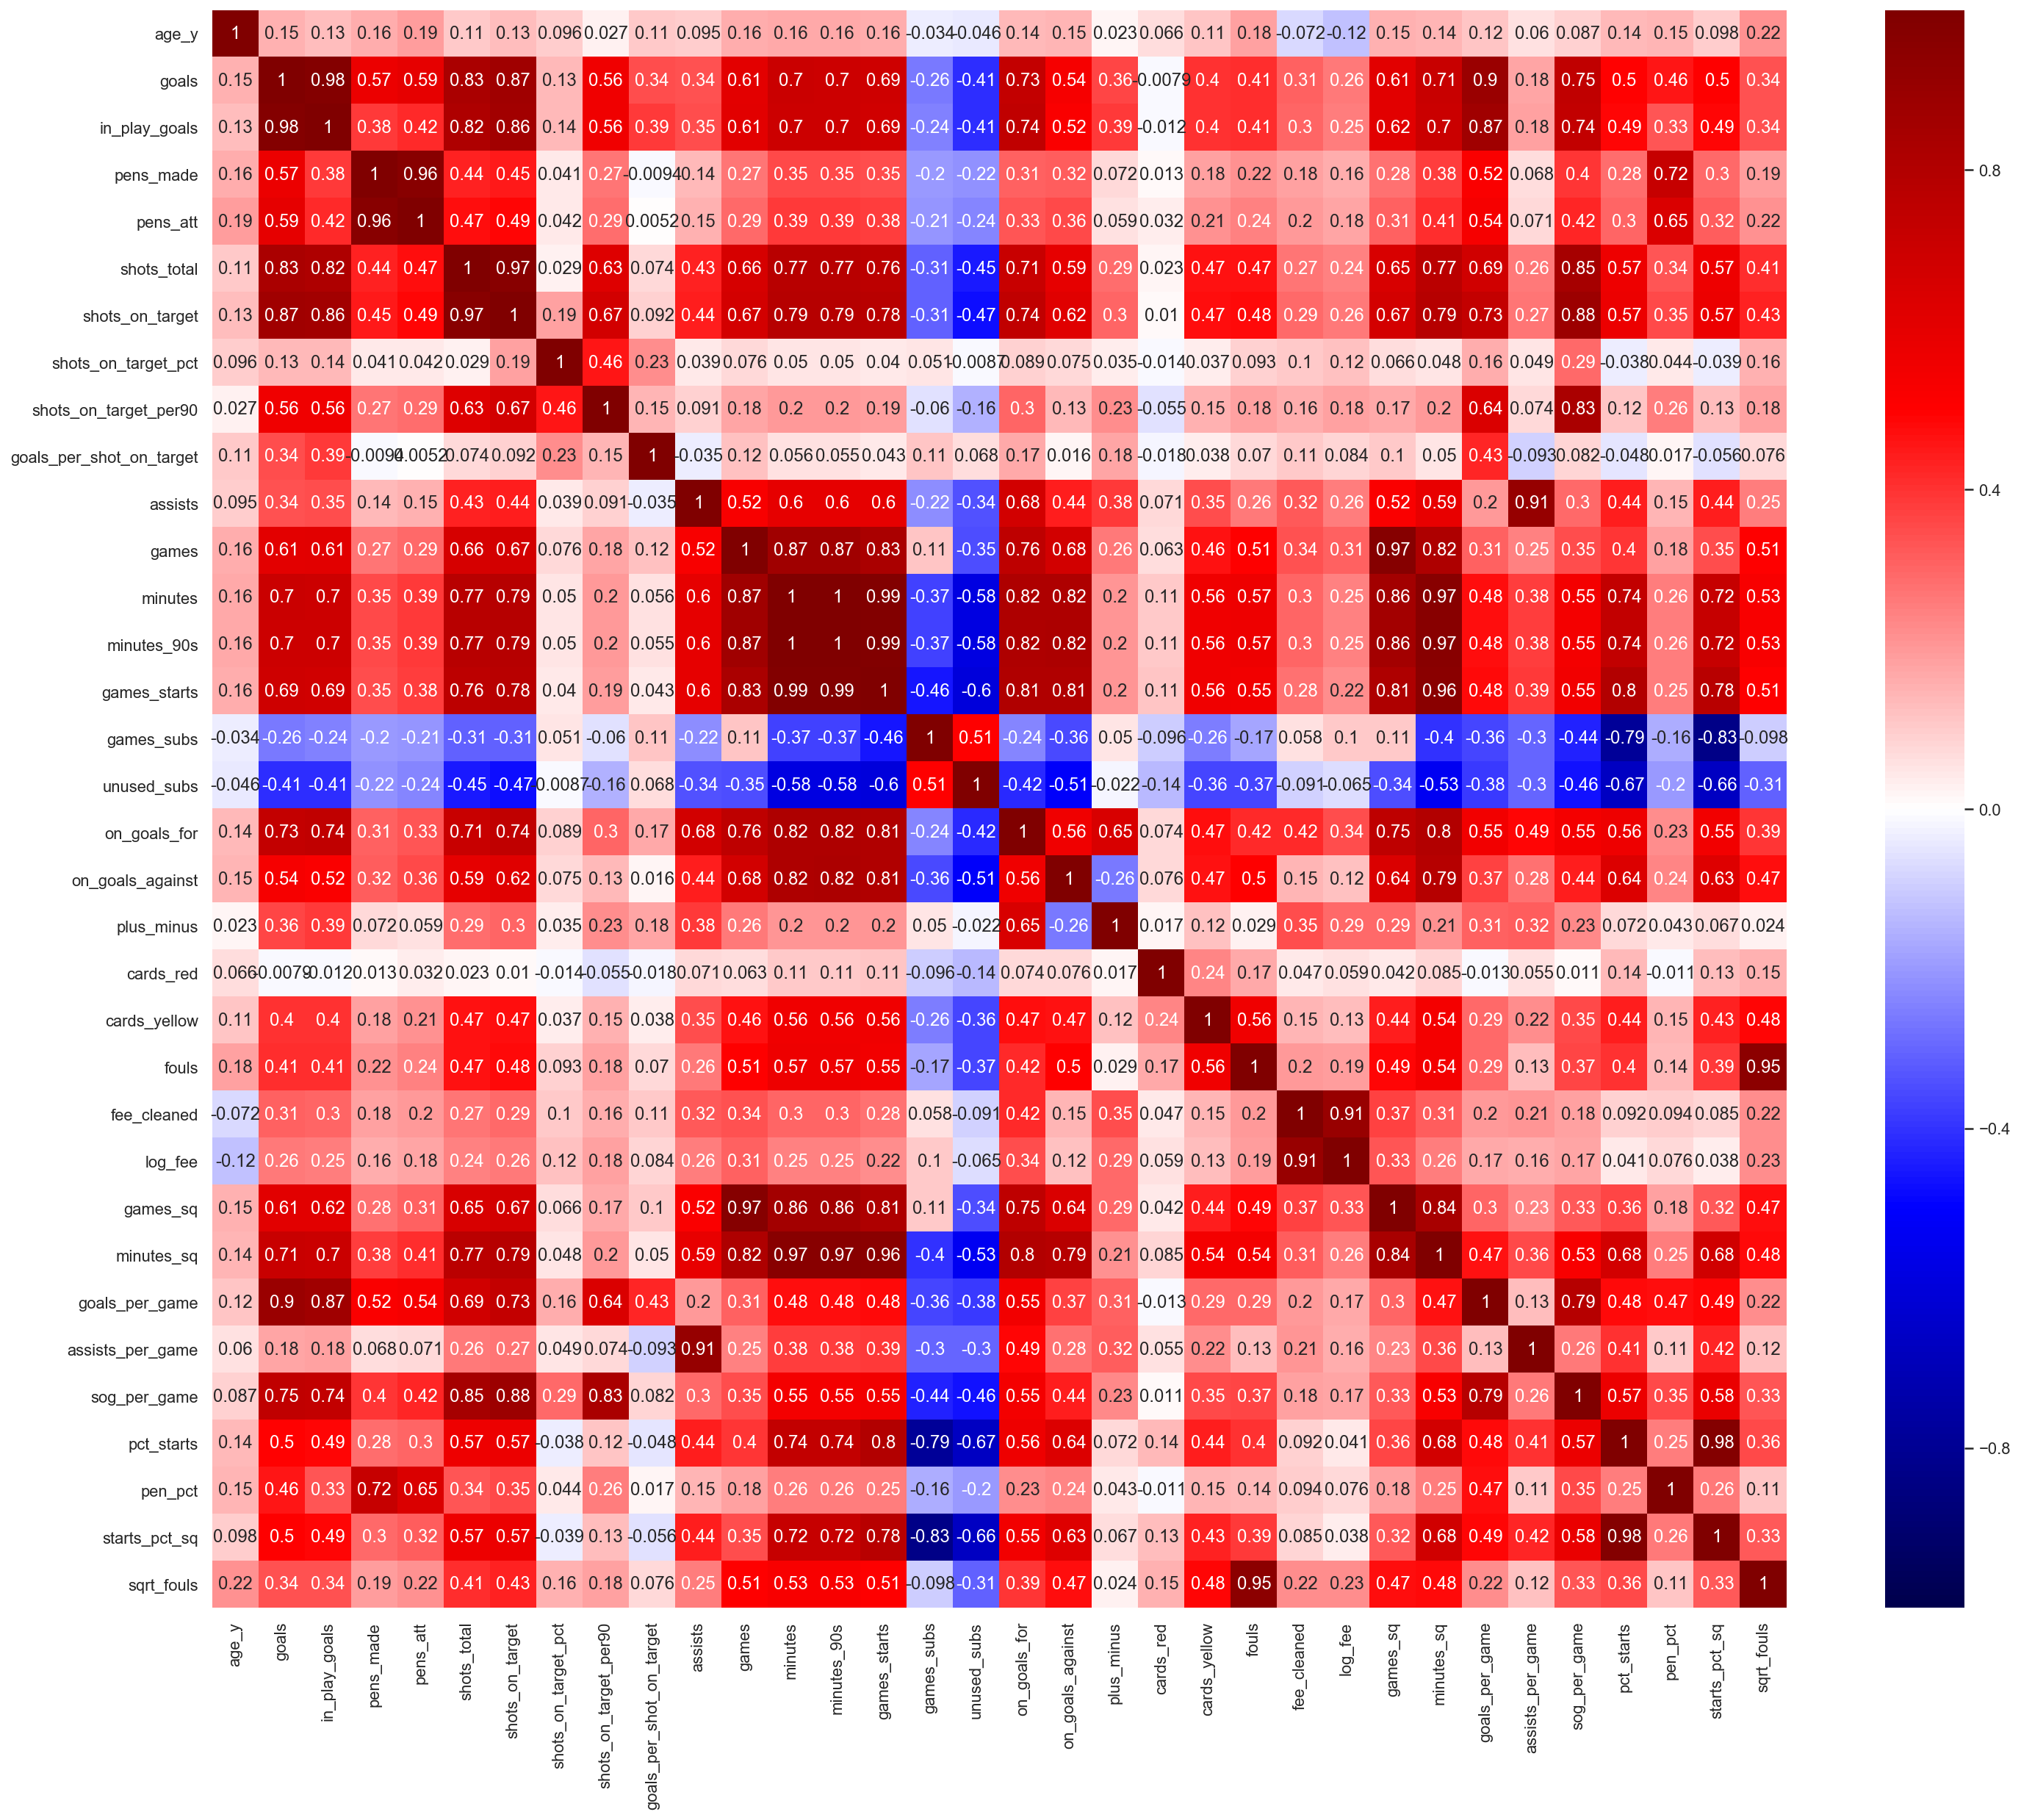

In [12]:
plt.figure(figsize=(24, 20))
sns.heatmap(target_data.corr(), cmap='seismic', annot=True, vmin=-1, vmax=1)

Through lots of trial and error I removed features if I saw that they had a high correlation with another feature. I repeatedly removed features and re-plotted the heatmap to see how correlations changed.

Eventually I settled on removing the following features

In [13]:
multicoll_cols = ['on_goals_against', 'in_play_goals', 'pens_att', 'minutes', 'shots_total', 'games_starts',
                  'minutes_90s', 'games', 'goals_per_game', 'log_fee', 'assists_per_game', 'fouls',
                  'sog_per_game', 'minutes_sq', 'games_subs']

## Find the optimal alpha for Ridge and Lasso regularization

In [14]:
X = target_data.drop(multicoll_cols, axis=1).drop('fee_cleaned', axis=1)
y = target_data.fee_cleaned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12)

scaler = StandardScaler()
scaler.fit(X_train)

X_tr_sc = scaler.transform(X_train)
X_te_sc = scaler.transform(X_test)

In [15]:
alphas = [.0001, .001, .01, 1, 10 , 100, 1000]

ridge_r2 = []
ridge_rmse = []
ridge_mae = []

lasso_r2 = []
lasso_rmse = []
lasso_mae = []

for a in alphas:
    
    lm_ridge = Ridge(alpha=a)
    lm_ridge.fit(X_tr_sc, y_train)
    lm_ridge_pred = lm_ridge.predict(X_te_sc)
    
    ridge_r2.append(r2_score(y_test, lm_ridge_pred))
    ridge_rmse.append(np.sqrt(mean_squared_error(y_test, lm_ridge_pred)))
    ridge_mae.append(mean_absolute_error(y_test, lm_ridge_pred))
    
    lm_lasso = Lasso(alpha=a)
    lm_lasso.fit(X_tr_sc, y_train)
    lm_lasso_pred = lm_lasso.predict(X_te_sc)
    
    lasso_r2.append(r2_score(y_test, lm_lasso_pred))
    lasso_rmse.append(np.sqrt(mean_squared_error(y_test, lm_lasso_pred)))
    lasso_mae.append(mean_absolute_error(y_test, lm_lasso_pred))
    
ridge_results = pd.DataFrame(index=alphas)
ridge_results['R2'] = ridge_r2
ridge_results['RMSE'] = ridge_rmse
ridge_results['MAE'] = ridge_mae

lasso_results = pd.DataFrame(index=alphas)
lasso_results['R2'] = lasso_r2
lasso_results['RMSE'] = lasso_rmse
lasso_results['MAE'] = lasso_mae

print('Ridge Results:\n', ridge_results, '\n')
print('Lasso Reults:\n', lasso_results)

Ridge Results:
                  R2      RMSE       MAE
0.0001     0.279659  7.144463  5.518388
0.0010     0.279660  7.144463  5.518388
0.0100     0.279661  7.144457  5.518389
1.0000     0.279775  7.143889  5.518590
10.0000    0.280284  7.141364  5.521166
100.0000   0.272107  7.181821  5.562060
1000.0000  0.196621  7.545027  5.949342 

Lasso Reults:
                  R2      RMSE       MAE
0.0001     0.279659  7.144464  5.518422
0.0010     0.279662  7.144452  5.518736
0.0100     0.279634  7.144591  5.521941
1.0000     0.177101  7.636140  6.001081
10.0000   -0.014429  8.478352  6.657860
100.0000  -0.014429  8.478352  6.657860
1000.0000 -0.014429  8.478352  6.657860


Looks like lower alpha is better for both ridge and lasso.

I will use .0001 for both

## Run all models and tune parameters

### I reran this a number of times, comparing the Lasso coefficients and the P values from statsmodels and dropping features as necessary.

In [16]:
data2 = target_data.drop(multicoll_cols, axis=1)

drop_cols = ['goals', 'shots_on_target', 'unused_subs', 'shots_on_target_per90', 'pen_pct', 'cards_yellow',
            'goals_per_shot_on_target', 'cards_red', 'plus_minus', 'games_sq', 'shots_on_target_pct', 'pct_starts']

X = data2.drop(drop_cols, axis=1).drop('fee_cleaned', axis=1)
y = data2.fee_cleaned

I increased the lasso alpha to .01 to get a better sense of how it would zero out coefficients


----- Linear Regression -----
R2: 0.277; RMSE: 7.16; MAE: 5.51

age_y           -0.403265
pens_made        0.430804
assists          0.391121
on_goals_for     0.174767
starts_pct_sq   -6.710623
sqrt_fouls       0.372084
dtype: float64

----- Ridge Regression -----
R2: 0.277; RMSE: 7.16; MAE: 5.51

age_y           -1.329383
pens_made        0.677340
assists          1.255494
on_goals_for     3.298927
starts_pct_sq   -1.974296
sqrt_fouls       0.829430
dtype: float64

----- Lasso Regression -----
R2: 0.276; RMSE: 7.16; MAE: 5.52

age_y           -1.314875
pens_made        0.663138
assists          1.243950
on_goals_for     3.288848
starts_pct_sq   -1.947280
sqrt_fouls       0.818134
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:     

/Users/noah/opt/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


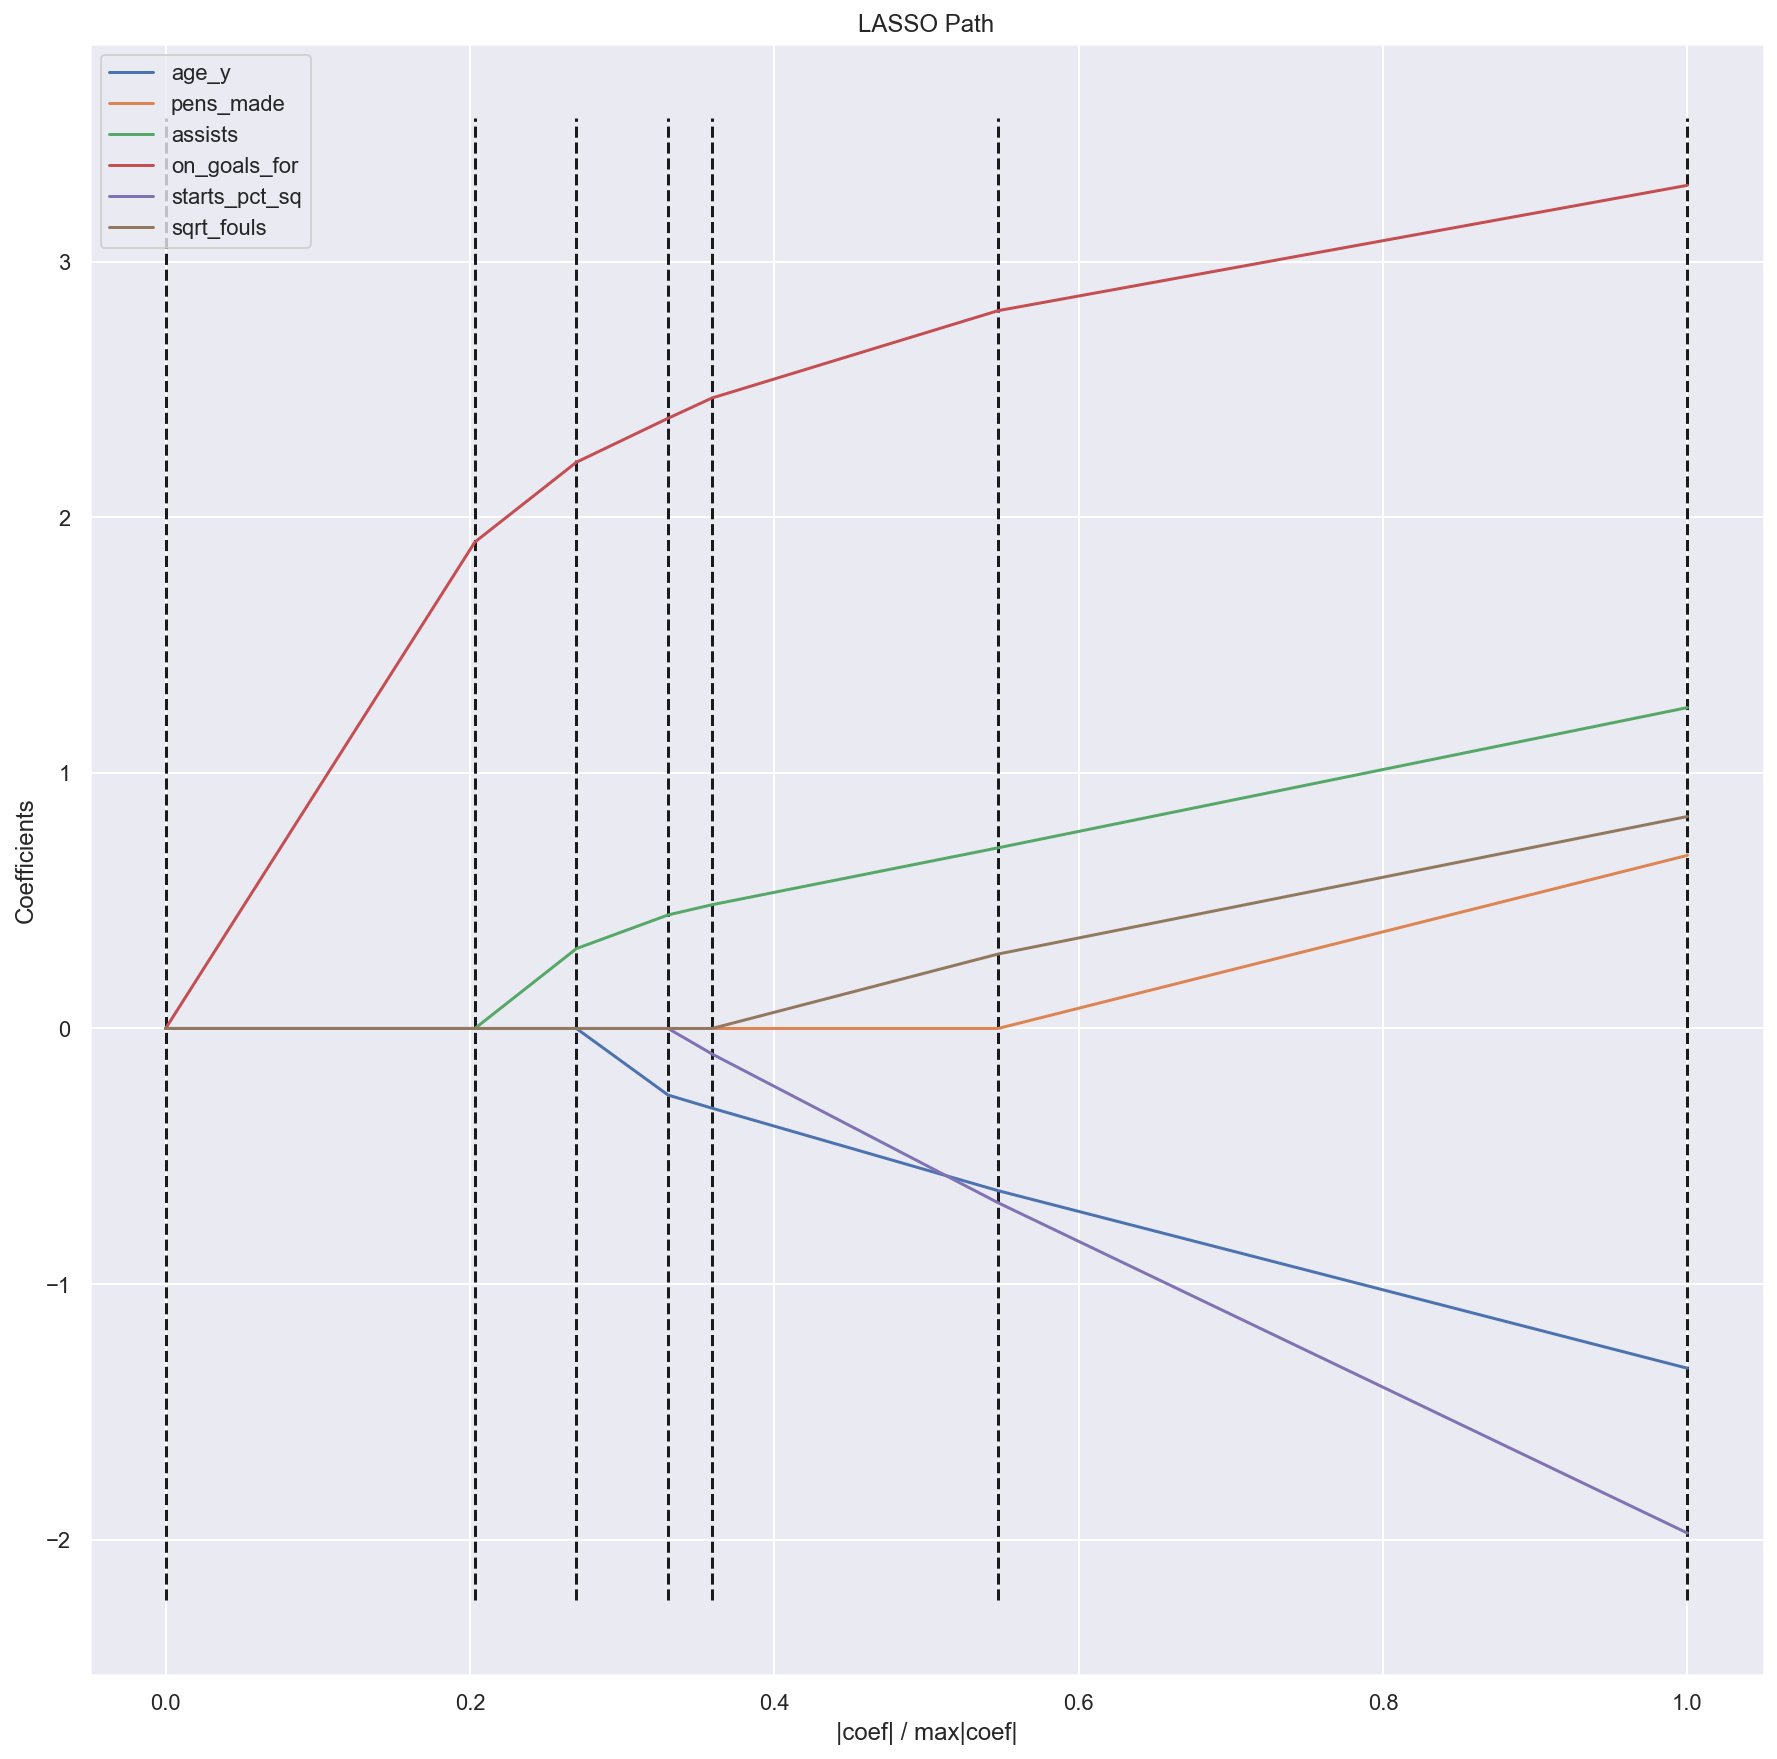

In [18]:
model_compare(X, y, .0001, .01)
lars_plot(X, y)

Some of these features are pretty weird, and the coefficients don't all make a lot of sense.

In particular, the games started percentage ^2 has a negative coefficient, meaning that starting a higher percentage of games decreases a player's value.

# Final Model

### The Ridge, Lasso, and regular Linear Regression came up with almost identical results for R^2, RMSE, and MAE, so I will use the regular Linear Regression for my final model

In [19]:
final_cols = ['age_y', 'assists', 'on_goals_for', 'starts_pct_sq', 'sqrt_fouls', 'pens_made']
# final_cols = ['age_y']

final_data = pd.read_csv('target_data_eng.csv', index_col=0)

X = final_data[final_cols]
y = final_data.fee_cleaned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12)

lm = LinearRegression()
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)

print('\n----- Linear Regression -----')
print(f'R2: {r2_score(y_test, lm_pred):.3f}; RMSE: {np.sqrt(mean_squared_error(y_test, lm_pred)):.2f}; MAE: {mean_absolute_error(y_test, lm_pred):.2f}\n')
print(pd.Series(dict(zip(X_test.columns, lm.coef_))))


----- Linear Regression -----
R2: 0.277; RMSE: 7.16; MAE: 5.51

age_y           -0.403265
assists          0.391121
on_goals_for     0.174767
starts_pct_sq   -6.710623
sqrt_fouls       0.372084
pens_made        0.430804
dtype: float64


## Results

### My final model has an $R^2$ of .277, Root Mean Squared Error of £7.16 million, and Mean Absolute Error of £5.51 million.

## Model evaluation

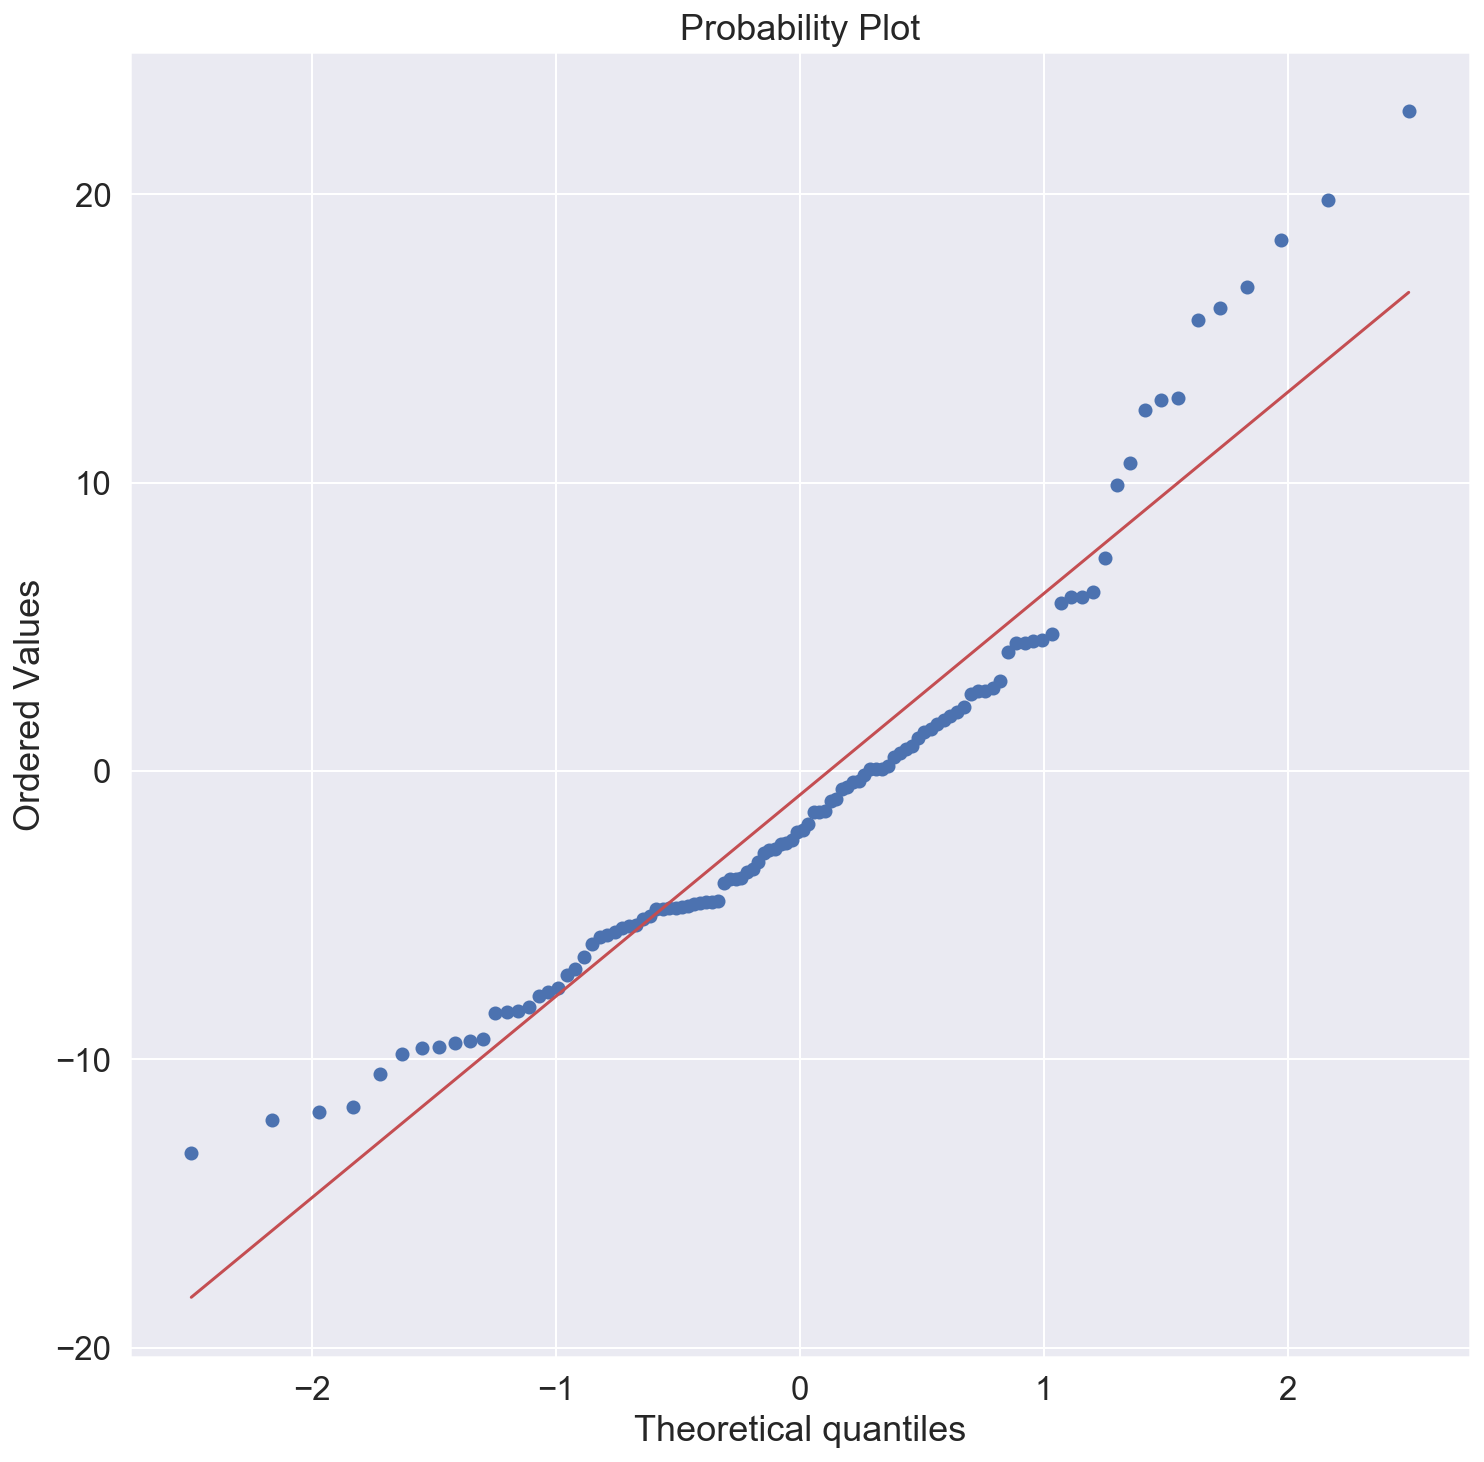

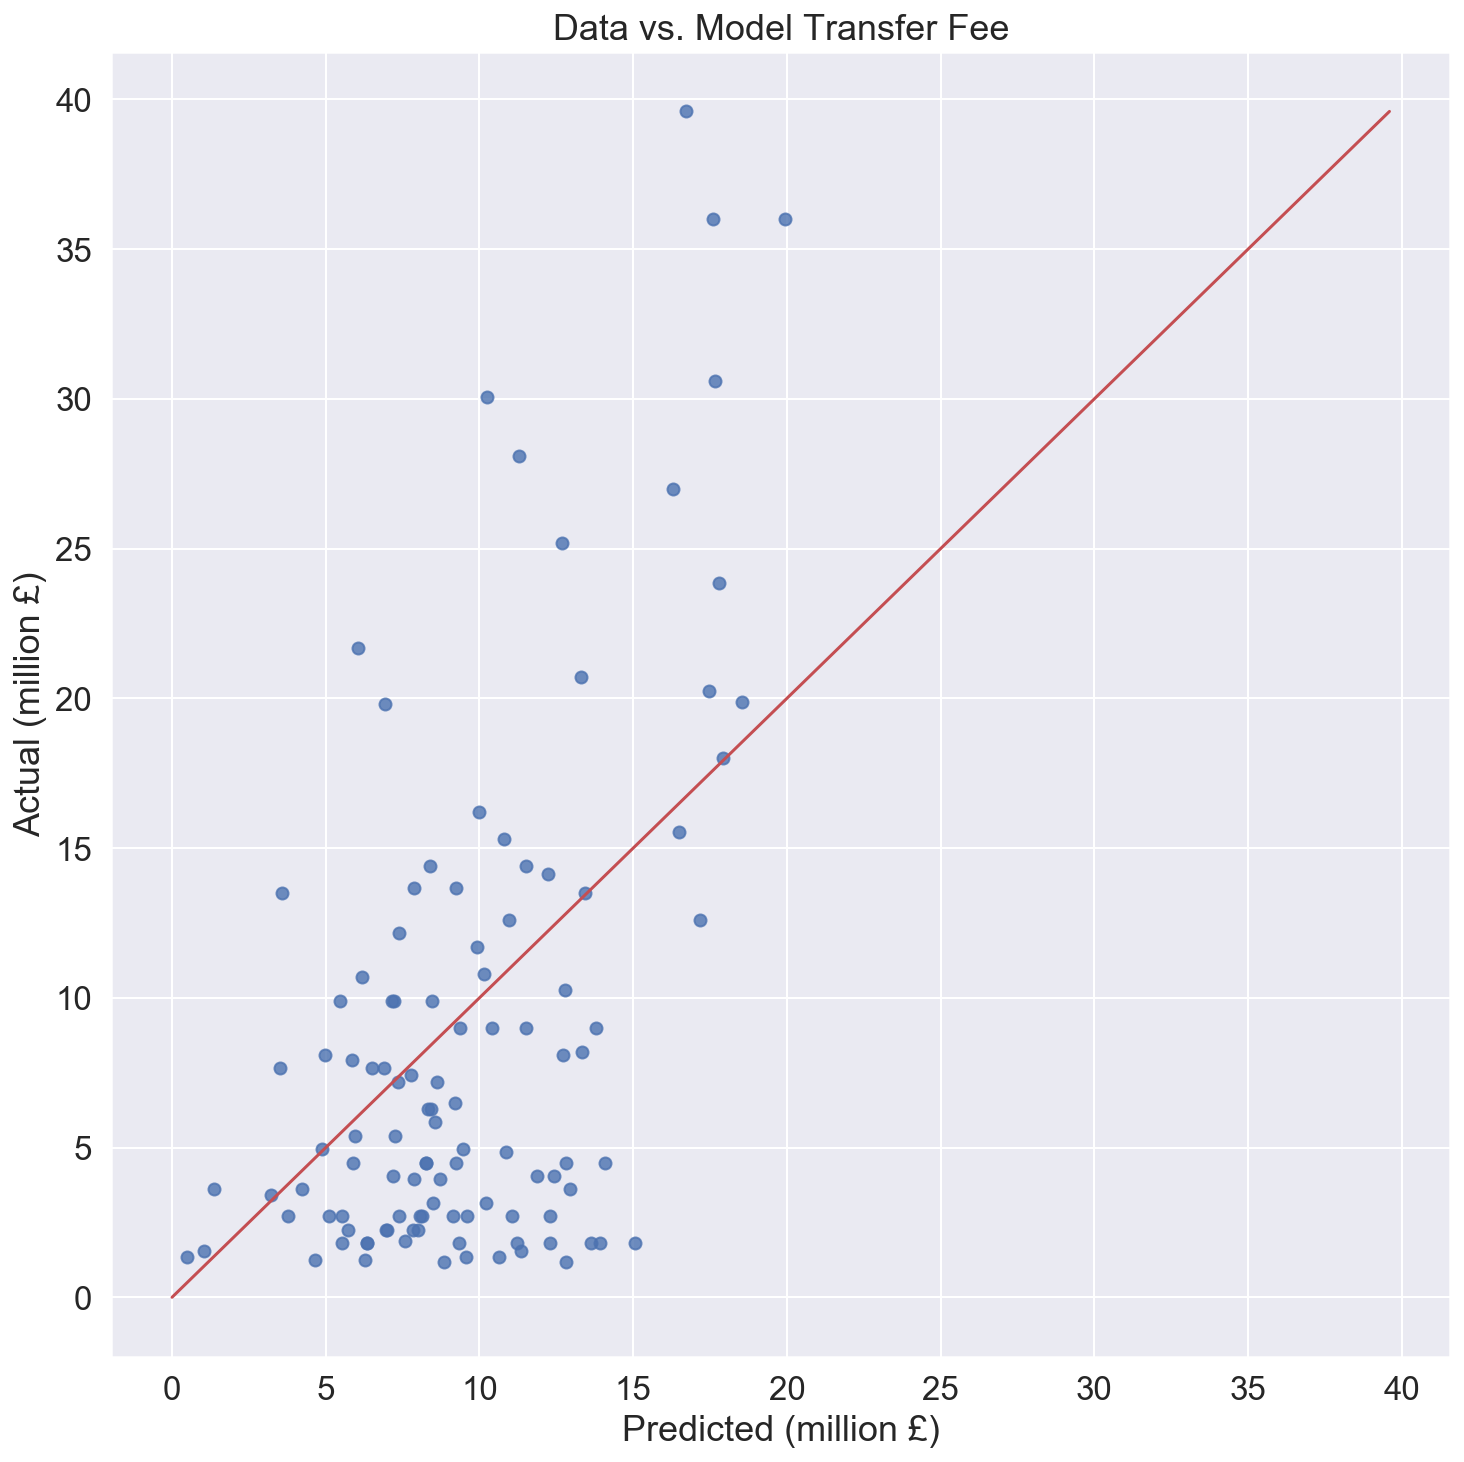

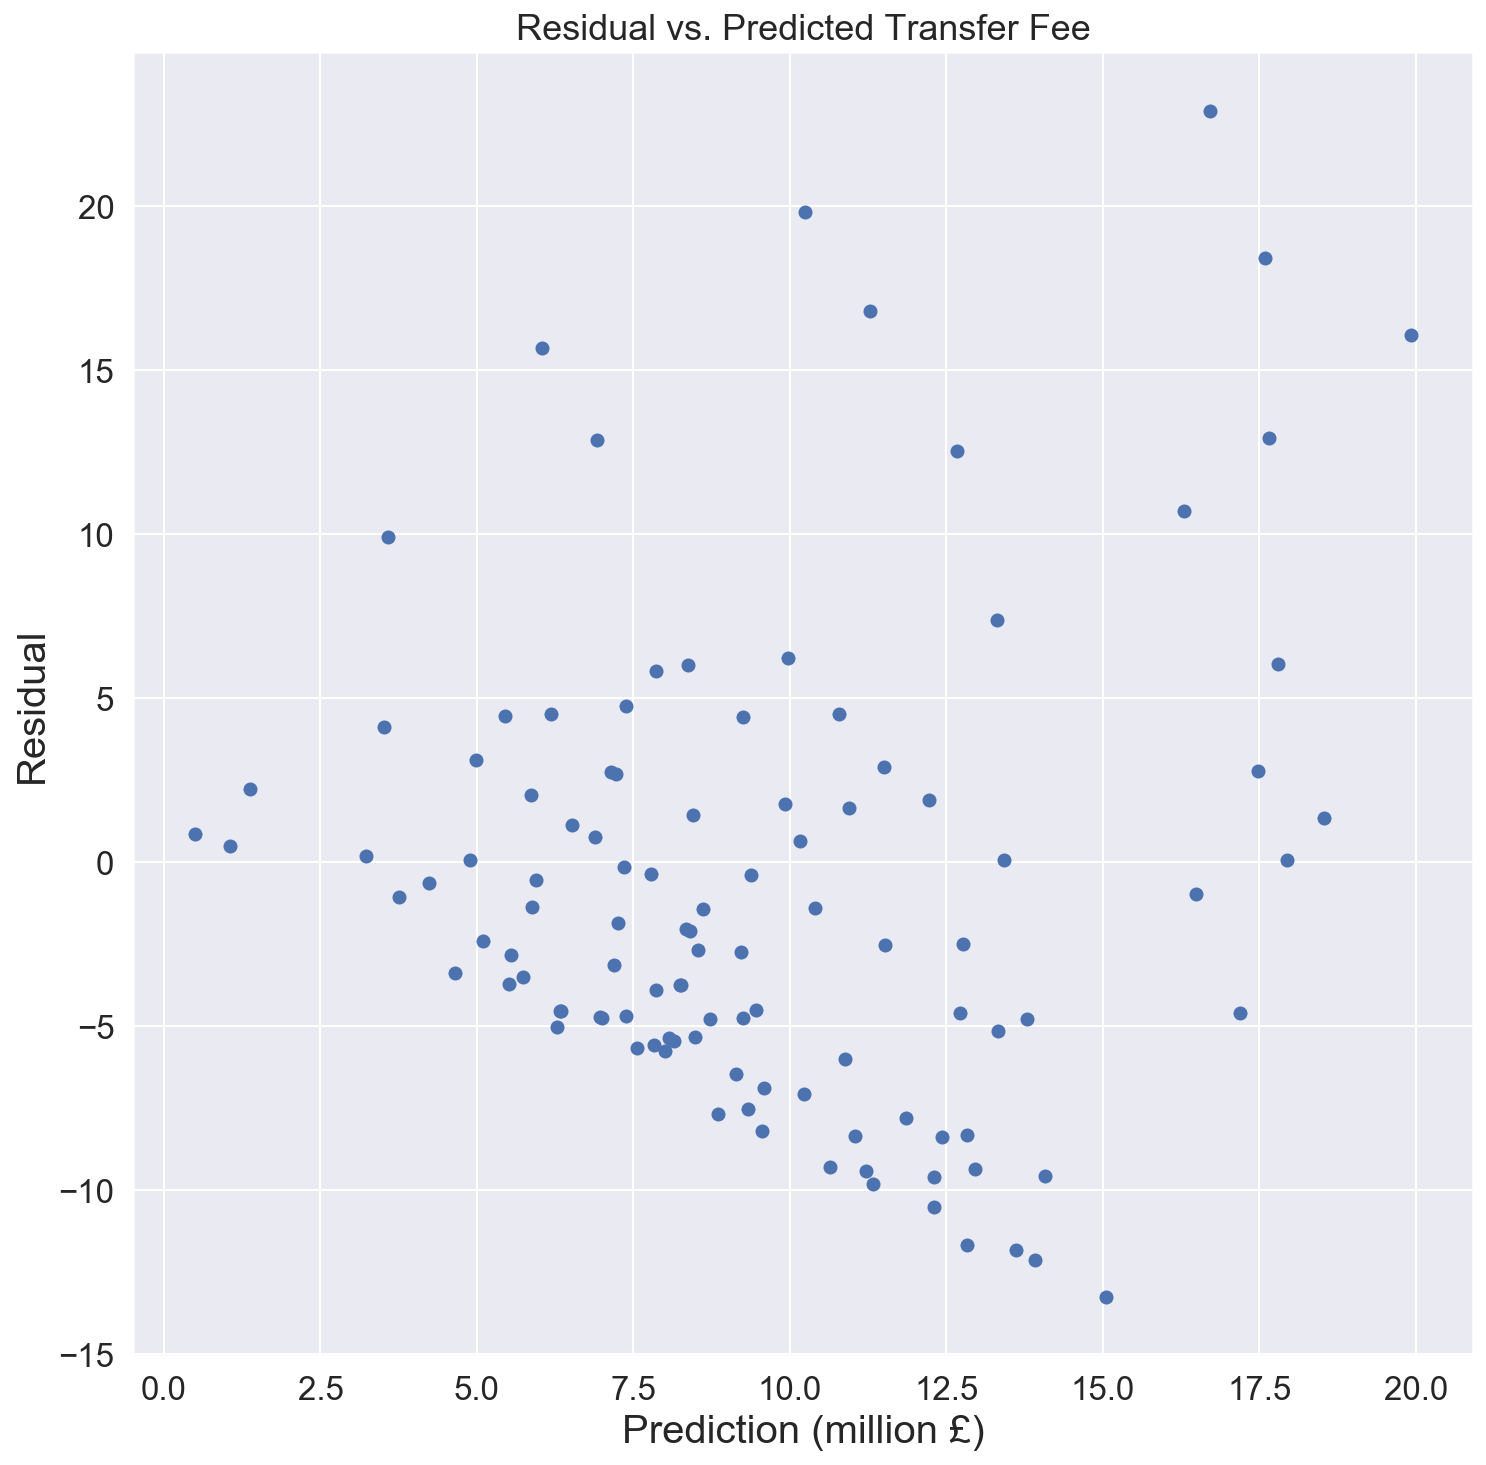

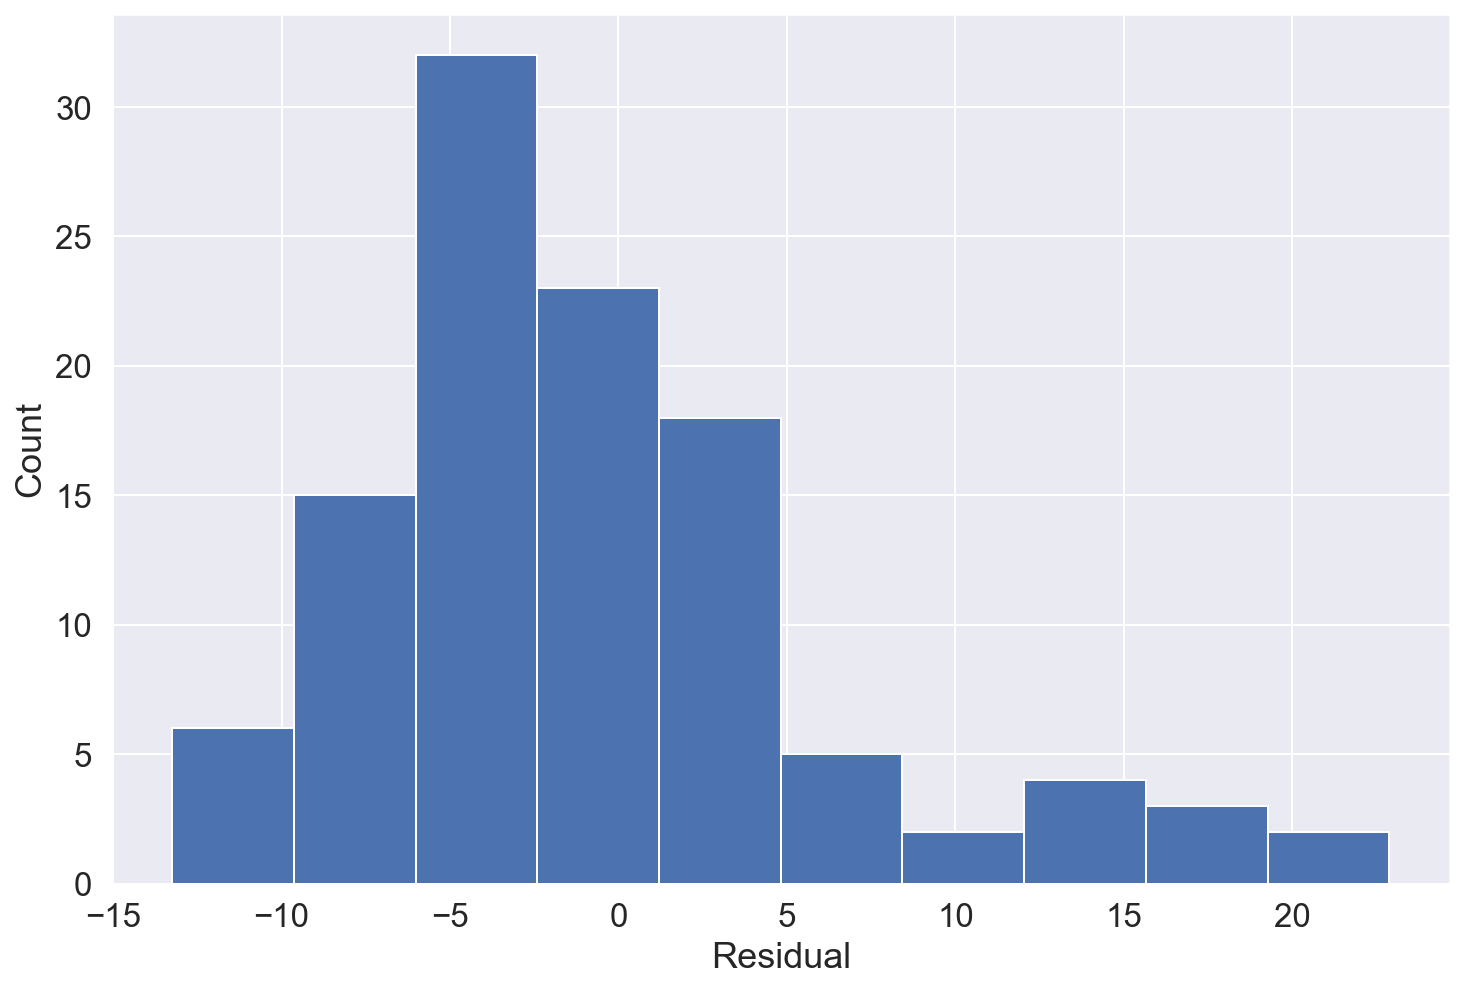

In [20]:
eval_plots(y_test, lm_pred)

# Overfitting

#### Using the features I selected for my final model, fitting a model to different random training sets produce wildly varying $R^2$ and RMSE. This shows that my model is overfitting.

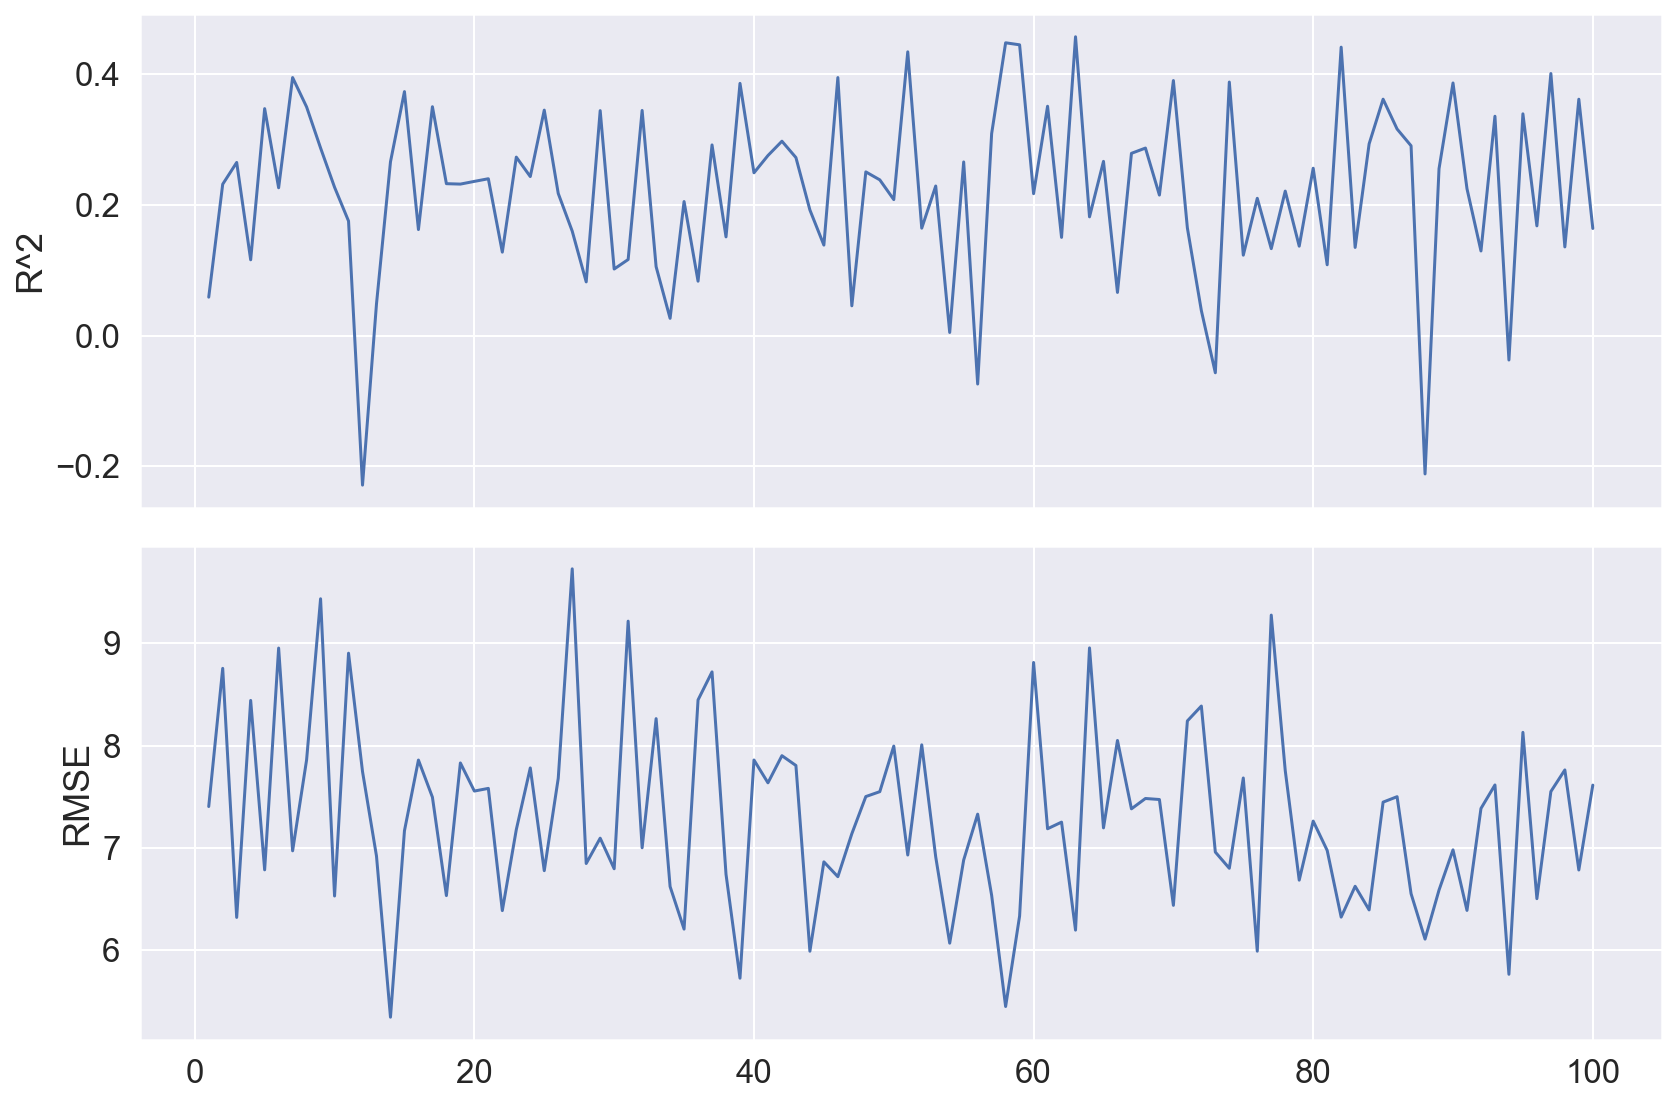

In [21]:
r2_overfit = []
rmse_overfit = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    pred = lm.predict(X_test)
    r2_overfit.append(r2_score(y_test, pred))
    rmse_overfit.append(np.sqrt(mean_squared_error(y_test, pred)))
    
fig, ax = plt.subplots(2, figsize=(12, 8), sharex=True)
ax[0].plot(np.arange(1, 101, 1), r2_overfit)
ax[0].set_ylabel('R^2')
ax[1].plot(np.arange(1, 101, 1), rmse_overfit)
ax[1].set_ylabel('RMSE')
plt.tight_layout()
# plt.savefig('overfitting.svg')